<a href="https://colab.research.google.com/github/cicerohen/hands-on-ml-book/blob/main/hands_on_chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Setup & Data Acquisition**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from pandas.plotting import scatter_matrix

# Load the data
housing_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/housing.csv')
housing = housing_df.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **2. The "Attribute X-Ray" (Exploratory Data Analysis)**

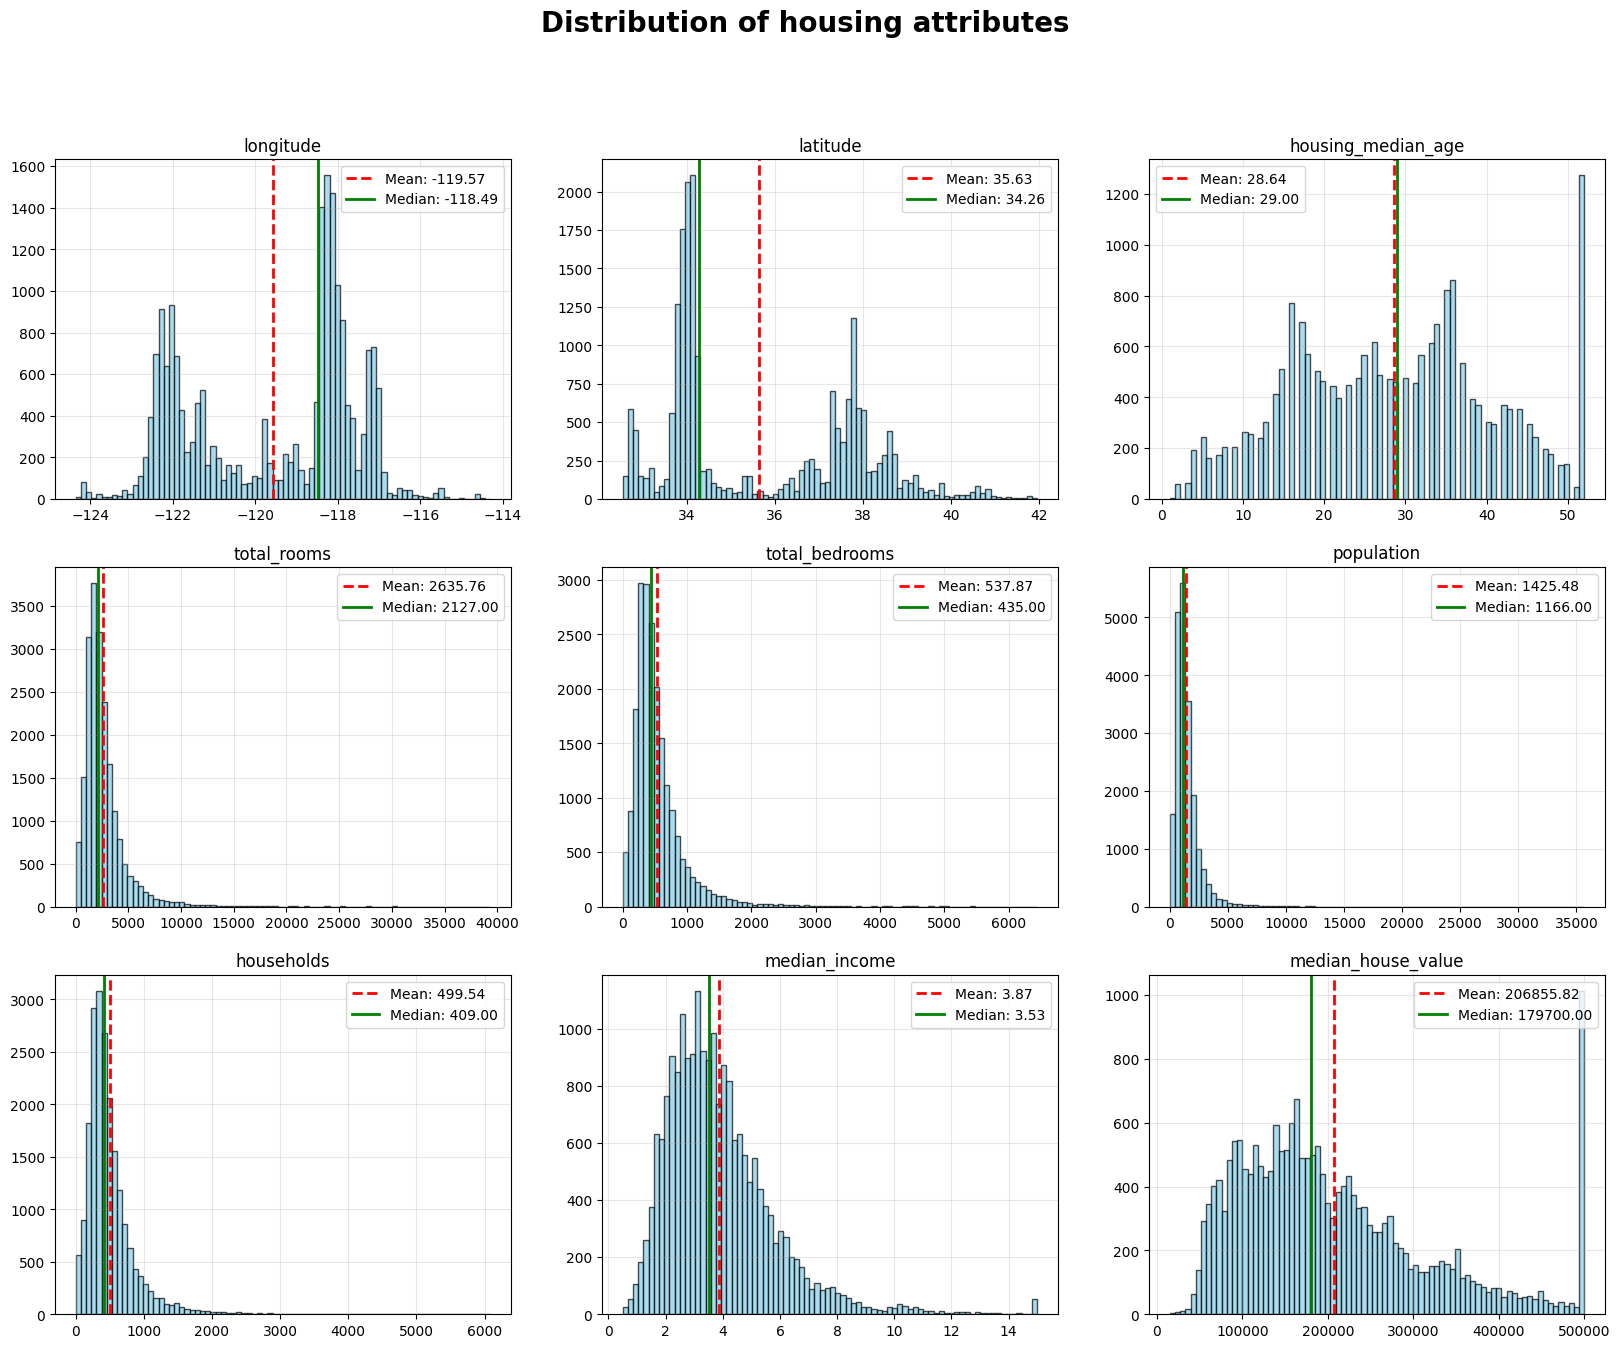

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

fig.suptitle('Distribution of housing attributes', fontsize=20, fontweight='bold')
for i, column in enumerate(housing_df.columns):
    if i < len(axes):
        axes[i].hist(housing_df[column].dropna(), bins=80, alpha=0.7, color='skyblue', edgecolor='black')
        mean_val = housing_df[column].mean()
        median_val = housing_df[column].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
        axes[i].set_title(column)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.show()

### **3. Creating a Representative Test Set**

In [28]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()

### **4. Data Preprocessing & Feature Engineering**

In [31]:
# Custom Transformer for Feature Engineering
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, 3] / X[:, 6]
        population_per_household = X[:, 5] / X[:, 6]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, 4] / X[:, 3]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Building the Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_labels = strat_train_set["median_house_value"].copy()
housing_features = strat_train_set.drop("median_house_value", axis=1)

housing_num = housing_features.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing_features)

### **5. Model Selection & Training**

In [32]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Decision Tree
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

# Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

# Cross-Validation
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


### **6. Fine-Tuning & Final Evaluation**

In [33]:
# Grid Search for Fine-Tuning
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

# Final Evaluation on Test Set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"Final RMSE on test set: {final_rmse}")

Final RMSE on test set: 47873.26095812988
